In [22]:
! pip install contractions

In [23]:

import pandas as pd
import re
from nltk.corpus import stopwords
import contractions
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import nltk
import seaborn as sns

nltk.download('stopwords')

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:

# Loading data
file_path = '/content/IMDB Dataset.csv'
imdb_data = pd.read_csv(file_path)

train_df = pd.read_csv('/content/IMDB Dataset.csv')

train_df.head(5)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [33]:

# Identifing duplicate reviews
num_duplicates = imdb_data.duplicated(subset=['review']).sum()
print(f'There are {num_duplicates} duplicate reviews present in the dataset.')


There are 418 duplicate reviews present in the dataset.


In [34]:

# Extracting positive and negative reviews
good_reviews = train_df[train_df['sentiment'] == 'positive']['review']
bad_reviews = train_df[train_df['sentiment'] == 'negative']['review']

# Displying sample reviews
print("Samples of good reviews\n", good_reviews[:5])
print("Samples of bad reviews\n", bad_reviews[:5])


Samples of good reviews
 0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
4    Petter Mattei's "Love in the Time of Money" is...
5    Probably my all-time favorite movie, a story o...
Name: review, dtype: object
Samples of bad reviews
 3     Basically there's a family where a little boy ...
7     This show was an amazing, fresh & innovative i...
8     Encouraged by the positive comments about this...
10    Phil the Alien is one of those quirky films wh...
11    I saw this movie when I was about 12 when it c...
Name: review, dtype: object


Sentiment counts after removing duplicates:
sentiment
positive    24884
negative    24698
Name: count, dtype: int64


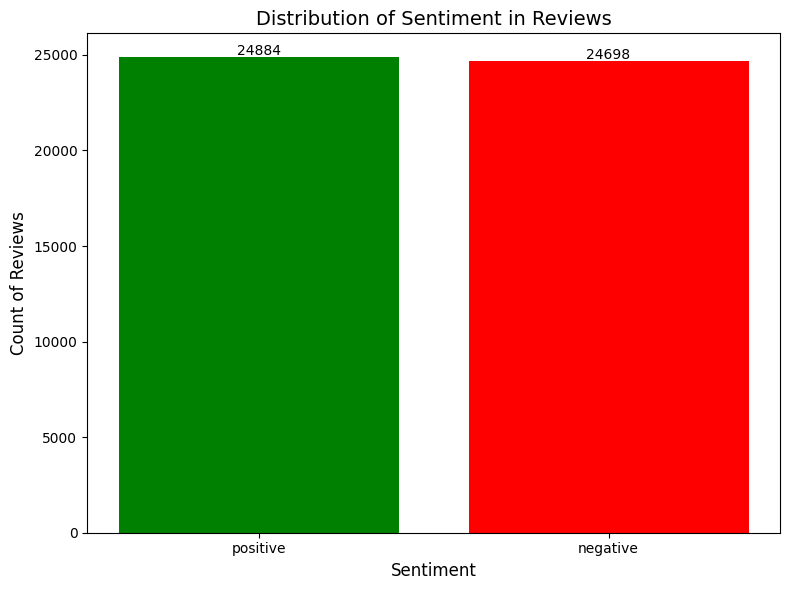

In [35]:
import matplotlib.pyplot as plt
import pandas as pd


train_df = pd.read_csv('/content/IMDB Dataset.csv')

# Droping duplicates
train_df.drop_duplicates(subset=['review'], keep='first', inplace=True)

# Calculating sentiment counts *after* dropping duplicates
sentiment_counts = train_df['sentiment'].value_counts()
print("Sentiment counts after removing duplicates:")
print(sentiment_counts)

# 4. Ploting the counts
def plot_counts(sentiment_counts):
    """
    Plots the counts of positive and negative reviews.

    Args:
        sentiment_counts (pd.Series): A Pandas Series containing the counts
                                      of each sentiment (positive and negative).
    """
    plt.rcParams['figure.figsize'] = (8, 6)  # Slightly larger for better readability

    # Using sentiment_counts directly for plotting
    plt.bar(
        sentiment_counts.index,  # Use sentiment labels as x-axis
        sentiment_counts.values,  # Use counts as heights of bars
        color=['Green' if label == 'positive' else 'Red' for label in sentiment_counts.index],  # Conditional coloring
    )
    # Adding labels and title
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('Count of Reviews', fontsize=12)
    plt.title('Distribution of Sentiment in Reviews', fontsize=14)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    # Adding value labels on top of bars
    for index, value in enumerate(sentiment_counts):
        plt.text(index, value + 100, str(value), ha='center', fontsize=10)  # Adjust the +100 for best label positioning

    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

plot_counts(sentiment_counts)


Positive Review Words:
 0    307
1    162
2    166
4    230
5    119
Name: review, dtype: int64
Negative Review Words:
 3     138
7     174
8     130
10     96
11    180
Name: review, dtype: int64


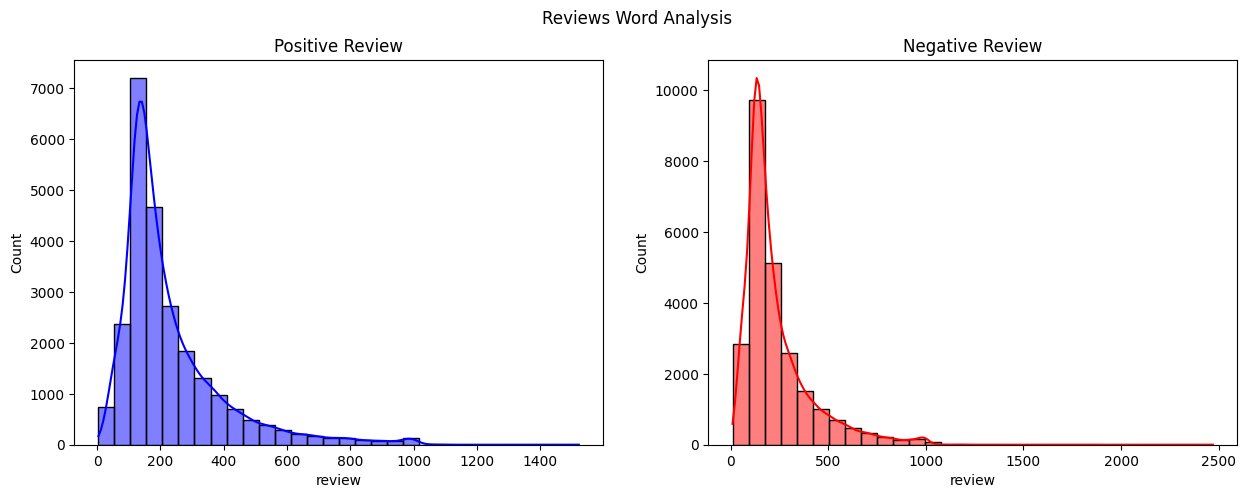

In [36]:

# Function to calculate word length
def cal_len(data):
    return len(data)

# Calculating word count per review
count_good_words = train_df[train_df['sentiment'] == 'positive']['review'].str.split().map(len)
count_bad_words = train_df[train_df['sentiment'] == 'negative']['review'].str.split().map(len)

# Displaying word counts
print("Positive Review Words:\n", count_good_words.head())
print("Negative Review Words:\n", count_bad_words.head())

# Function to plot word distribution
def plot_count(count_ones, count_zeros, title_1, title_2, subtitle):
    # Importing seaborn within the function if it's not already imported globally (not necessary)
    import seaborn as sns
    import matplotlib.pyplot as plt  # Importing matplotlib for plotting functionalities
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(count_zeros, ax=ax1, color='Blue', kde=True, bins=30)
    ax1.set_title(title_1)
    sns.histplot(count_ones, ax=ax2, color='Red', kde=True, bins=30)
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()

# Plot word distribution in positive and negative reviews
plot_count(count_good_words, count_bad_words, "Positive Review", "Negative Review", "Reviews Word Analysis")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.6241 - loss: 0.6335 - val_accuracy: 0.8439 - val_loss: 0.3584 - learning_rate: 0.0010
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.8557 - loss: 0.3476 - val_accuracy: 0.8606 - val_loss: 0.3231 - learning_rate: 0.0010
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 44s 175ms/step - accuracy: 0.9051 - loss: 0.2528 - val_accuracy: 0.8619 - val_loss: 0.3357 - learning_rate: 0.0010
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 146ms/step - accuracy: 0.9434 - loss: 0.1774 - val_accuracy: 0.8624 - val_loss: 0.3432 - learning_rate: 2.0000e-04
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8591 - loss: 0.3250
Test Accuracy: 0.8606


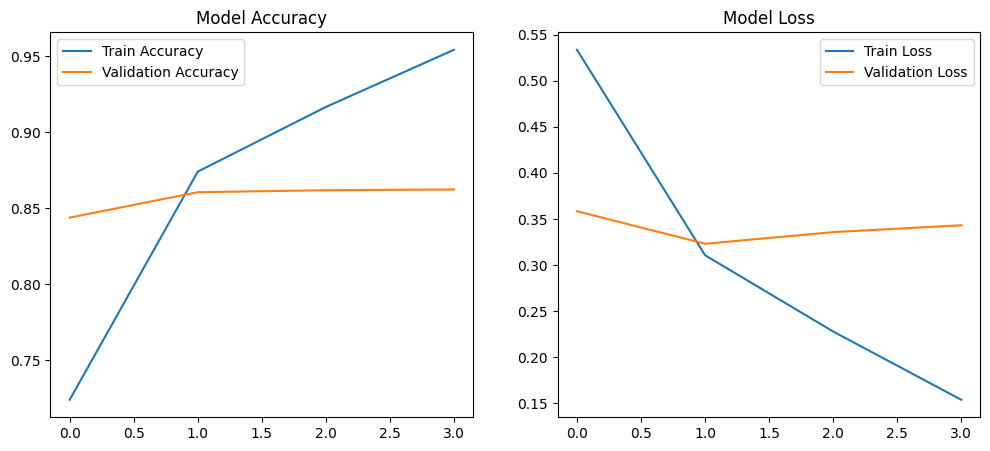

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Review Sentiment: Positive (Score: 1.00)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Sample Review Predictions:
Review: The movie was fantastic! I loved it.
Predicted Sentiment: Positive
Prediction Score: 0.95
--------------------------------------------------
Review: It was a waste of time. Terrible story.
Predicted Sentiment: Negative
Prediction Score: 0.01
--------------------------------------------------
Review: An average film with decent acting but poor direction.
Predicted Sentiment: Negative
Prediction Score: 0.01
--------------------------------------------------
Review: Absolutely brilliant! A must-watch for everyone.
Predicted Sentiment: Positive
Prediction Score: 0.94
--------------------------------------------------
Review: The plot was dull and predictable. Not worth it.
Predicted Sentiment: Negative
Prediction Score: 0.03
--------------------------------------------------
Review: An exhilarating experience! The visuals were stunning.
P

In [37]:

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

#Data cleaning
# Load stopwords
stop_words = set(stopwords.words('english'))

# Encode sentiment labels as numeric values
imdb_data['sentiment'] = imdb_data['sentiment'].map({'positive': 1, 'negative': 0})

# Ensureing data types are correct
imdb_data['sentiment'] = imdb_data['sentiment'].astype(int)

# Define the clean_text function to include stopword removal
def clean_text(text):
    text = re.sub('<.*?>', ' ', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    text = text.lower()  # Convert to lowercase
    text = contractions.fix(text)  # Expand contractions like "don't" to "do not"
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the clean_text function to the reviews
imdb_data['review'] = imdb_data['review'].apply(clean_text)

# Checking the first few rows after cleaning
imdb_data.head(10)

# Download stopwords
nltk.download('stopwords')

# Tokenization and Padding
max_words = 10000  # Adjusted vocab size
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")  # Use <OOV> token
tokenizer.fit_on_texts(imdb_data['review'])  # Fit on cleaned data

X_sequences = tokenizer.texts_to_sequences(imdb_data['review'])  # Useing cleaned data
max_len = 150  # Adjusted max length
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post', truncating='post')
y_labels = np.array(imdb_data['sentiment'])  # Useing cleaned data

# Spliting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_labels, test_size=0.2, random_state=42)

# CNN Model Definition
embedding_dim = 32  # Reduced embedding dimension

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
    Conv1D(128, 5, activation='relu'), # Convolutional Layer
    GlobalMaxPooling1D(),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.00001)

# Training the model
batch_size = 256  # Increased batch size
epochs = 5  # Reduced epochs, relying on EarlyStopping
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

# Evaluating Model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Sample Reviews for Testing
sample_reviews = [
    "The movie was fantastic! I loved it.",
    "It was a waste of time. Terrible story.",
    "An average film with decent acting but poor direction.",
    "Absolutely brilliant! A must-watch for everyone.",
    "The plot was dull and predictable. Not worth it.",
    "An exhilarating experience! The visuals were stunning.",
    "I fell asleep halfway through. It was boring.",
    "One of the best movies I've ever seen.",
    "The characters lacked depth, and the story was weak.",
    "Loved the chemistry between the leads! So heartwarming."
]
#Defineing The review function
def review(text):
    clean_review = clean_text(text)
    sequence = tokenizer.texts_to_sequences([clean_review])
    padded = pad_sequences(sequence, maxlen=150, padding='post', truncating='post')
    prediction = model.predict(padded)
    return "Positive" if prediction[0] > 0.5 else "Negative", prediction[0][0] # Extract the score value from the array

example_review = "The movie was fantastic with great performances."
sentiment, score = review(example_review)
print(f'Review Sentiment: {sentiment} (Score: {score:.2f})') # Now score is a float

# Preprocess the sample reviews
cleaned_sample_reviews = [clean_text(review) for review in sample_reviews]

# Convert the sample reviews to sequences
sample_sequences = tokenizer.texts_to_sequences(cleaned_sample_reviews)

# Pad the sequences to match the input length of the model
sample_padded = pad_sequences(sample_sequences, maxlen=max_len)

# Make predictions on the sample reviews
sample_predictions = model.predict(sample_padded, verbose=1)

# Print the predictions along with the corresponding sentiment
print("Sample Review Predictions:")
for review, prediction in zip(sample_reviews, sample_predictions):
    sentiment = "Positive" if prediction[0] > 0.5 else "Negative"
    print(f"Review: {review}")
    print(f"Predicted Sentiment: {sentiment}")
    print(f"Prediction Score: {prediction[0]:.2f}")  # Access the score correctly
    print("-" * 50)
